# Part 1

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [1]:
!pip install gym


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
from collections import defaultdict
import tqdm
import random
from itertools import product

import numpy as np
import matplotlib.pyplot as plt


from blackjack import BlackjackEnv, BlackjackEnvDouble, BlackjackEnvDoubleDeck

In [3]:
def obs_to_state(obs):
    obs = (obs[0] - 4, obs[1] - 1) + obs[2:]
    return tuple(map(int, obs))

def calc_reward(env, pi, episodes):
    env.seed(1)
    total_reward = 0
    for _ in range(episodes):
        obs = env.reset()
        state = obs_to_state(obs)
        done = False
        while not done:
            action = pi[state]
            obs, reward, done, _ = env.step(action)
            state = obs_to_state(obs)
            if done:
                total_reward += reward
    return total_reward

def run_episode_actions(env, pi, eps, nA):
    obs = env.reset()
    state = obs_to_state(obs)
    next_action = pi[state] if np.random.rand() > eps else np.random.randint(nA)
    states, actions, rewards = [state], [next_action], [0]
    done = False
    while not done:
        obs, reward, done, _ = env.step(next_action)
        state = obs_to_state(obs)
        states.append(state)
        next_action = pi[state] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        rewards.append(reward)
    return states, actions, rewards

def get_random_Q(nS, nA, final_states):
    Q = np.random.random(size=nS + (nA, ))
    Q[final_states, :, :, :] = 0.0
    return Q

def init_C(ns, nA):
    C = np.zeros(nS + (nA, ), dtype=np.float32)
    return C

def compute_policy_by_Q(Q, nS):
    return np.argmax(Q, axis=len(nS))

def update_lists(s, a, g, w, Q, C):
    C[s + (a, )] = C[s + (a, )] + w
    Q[s + (a, )] = Q[s + (a, )] + (g - Q[s][a]) * w / C[s][a]
    return Q, C

def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0):
    g, w, prob_best_action = 0., 1., 1 - (nA - 1) * epsilon / nA

    Q, C = update_lists(states[-1], actions[-1], g, w, Q, C)
    
    for t in range(len(states) - 2, -1, -1):
        if actions[t+1] != pi[states[t+1]]:
            break
            
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]

        update_lists(states[t], actions[t], g, w, Q, C)
    return Q, C

In [4]:
env = BlackjackEnv(natural=True)
nS = (28, 10, 2)
nA = 2
final_states = tuple(range(18, 28))

In [5]:
pi = np.ones(nS, dtype=np.int8)
pi[15:, :, :] = 0

In [6]:

calc_reward(env, pi, episodes=100_000)

-17945.0

In [7]:
total_episodes = 100_000
nS = (28, 10, 2)
nA = 2
final_states = tuple(range(18, 28))
params_dict = defaultdict(dict)


for gamma in np.linspace(0.5, 1, 6):
    for eps in np.linspace(0.0, 0.5, 6):
        env = BlackjackEnv(natural=True)
        Q = get_random_Q(nS, nA, final_states=final_states)
        pi = compute_policy_by_Q(Q, nS)
        C = init_C(nS, nA)
        training_rewards = []

        for i in tqdm.tqdm(range(total_episodes)):
            states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
            training_rewards.append(rewards[-1])
            Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=eps, gamma=gamma)
            pi = compute_policy_by_Q(Q, nS)

        params_dict[gamma][eps] = np.cumsum(training_rewards)
        
        env.close()

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13223.21it/s]


Text(0, 0.5, 'Текущая оценка по gamma')

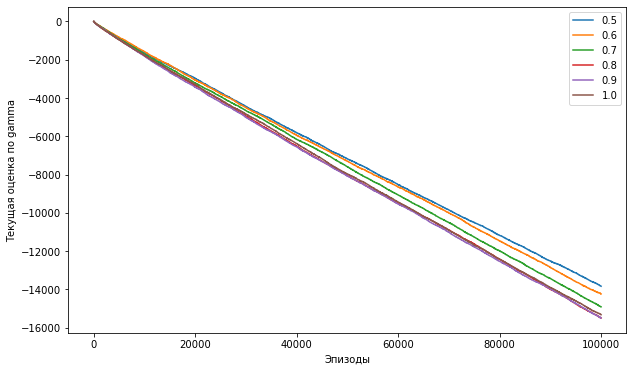

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, (key, eps_dict) in enumerate(params_dict.items()):
    plt.plot(np.mean(np.array(list(eps_dict.values())), axis=0), label=key, color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка по gamma")

Text(0, 0.5, 'Текущая оценка по eps')

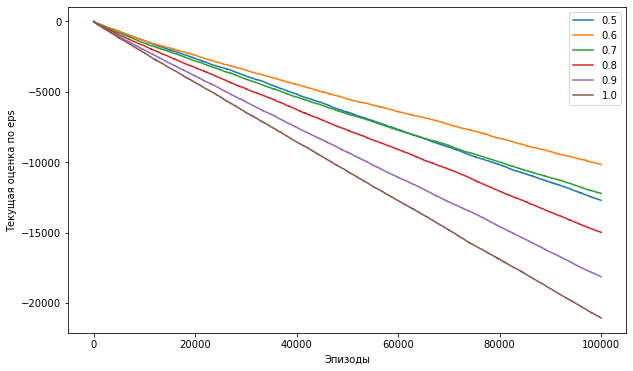

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, eps in enumerate(np.linspace(0.5, 1, 6)):
    array = [list(eps_dict.values())[i] for eps_dict in params_dict.values()]
    plt.plot(np.mean(np.array(array), axis=0), label=eps, color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка по eps")

In [10]:
total_episodes = 2_000_000
nS = (28, 10, 2)
nA = 2
final_states = tuple(range(18, 28))
env = BlackjackEnv(natural=True)
Q = get_random_Q(nS, nA, final_states=final_states)
pi = compute_policy_by_Q(Q, nS)
C = init_C(nS, nA)
training_rewards = []
eps = 0.6
gamma = 0.5

for i in tqdm.tqdm(range(total_episodes)):
    states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
    training_rewards.append(rewards[-1])
    Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=eps, gamma=gamma)
    pi = compute_policy_by_Q(Q, nS)

env.close()

100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [02:46<00:00, 12003.52it/s]


In [11]:
calc_reward(env, pi, episodes=100_000)


-3428.0

# Part 2

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [13]:
total_episodes = 100_000
nS = (28, 10, 2)
nA = 3
final_states = tuple(range(18, 28))
params_dict = defaultdict(dict)

for gamma in np.linspace(0.5, 1, 6):
    for eps in np.linspace(0.0, 0.5, 6):
        env = BlackjackEnvDouble(natural=True)
        Q = get_random_Q(nS, nA, final_states=final_states)
        pi = compute_policy_by_Q(Q, nS)
        C = init_C(nS, nA)
        training_rewards = []

        for i in tqdm.tqdm(range(total_episodes)):
            states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
            training_rewards.append(rewards[-1])
            Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=eps, gamma=gamma)
            pi = compute_policy_by_Q(Q, nS)

        params_dict[gamma][eps] = np.cumsum(training_rewards)
        env.close()

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13741.60it/s]


Text(0, 0.5, 'Текущая оценка по gamma')

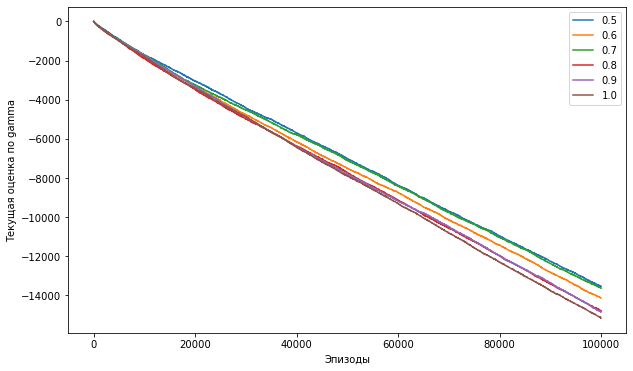

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, (key, eps_dict) in enumerate(params_dict.items()):
    plt.plot(np.mean(np.array(list(eps_dict.values())), axis=0), label=key, color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка по gamma")

Text(0, 0.5, 'Текущая оценка по eps')

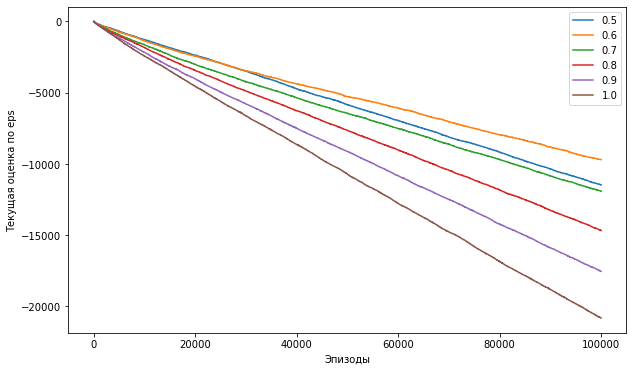

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, eps in enumerate(np.linspace(0.5, 1, 6)):
    array = [list(eps_dict.values())[i] for eps_dict in params_dict.values()]
    plt.plot(np.mean(np.array(array), axis=0), label=eps, color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка по eps")

In [16]:
total_episodes = 2_000_000
nS = (28, 10, 2)
nA = 3
final_states = tuple(range(18, 28))
env = BlackjackEnvDouble(natural=True)
Q = get_random_Q(nS, nA, final_states=final_states)
pi = compute_policy_by_Q(Q, nS)
C = init_C(nS, nA)
training_rewards = []
eps = 0.6
gamma = 0.5

for i in tqdm.tqdm(range(total_episodes)):
    states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
    training_rewards.append(rewards[-1])
    Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=eps, gamma=gamma)
    pi = compute_policy_by_Q(Q, nS)

env.close()

100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [02:12<00:00, 15139.33it/s]


In [17]:
calc_reward(env, pi, episodes=100_000)


-1.0

# Part 3

Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [ ]:
total_episodes = 300_000
nS = (28, 10, 2, 65, 2)
nA = 3
final_states = tuple(range(18, 28))
params_dict = defaultdict(dict)

for gamma in np.linspace(0.5, 1, 6):
    for eps in np.linspace(0.0, 0.5, 6):
        env = BlackjackEnvDoubleDeck(natural=True)
        Q = get_random_Q(nS, nA, final_states=final_states)
        pi = compute_policy_by_Q(Q, nS)
        C = init_C(nS, nA)
        training_rewards = []

        for i in tqdm.tqdm(range(total_episodes)):
            states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
            training_rewards.append(rewards[-1])
            Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=eps, gamma=gamma)
            pi = compute_policy_by_Q(Q, nS)

        params_dict[gamma][eps] = np.cumsum(training_rewards)
        env.close()

 54%|██████████████████████████████████████▋                                 | 161347/300000 [02:22<02:01, 1143.18it/s]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, (key, eps_dict) in enumerate(params_dict.items()):
    plt.plot(np.mean(np.array(list(eps_dict.values())), axis=0), label=key, color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка по gamma")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, eps in enumerate(np.linspace(0.5, 1, 6)):
    array = [list(eps_dict.values())[i] for eps_dict in params_dict.values()]
    plt.plot(np.mean(np.array(array), axis=0), label=eps, color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка по eps")

In [ ]:
total_episodes = 2_000_000
nS = (28, 10, 2, 65, 2)
nA = 3
final_states = tuple(range(18, 28))
env = BlackjackEnvDoubleDeck(natural=True)
Q = get_random_Q(nS, nA, final_states=final_states)
pi = compute_policy_by_Q(Q, nS)
C = init_C(nS, nA)
training_rewards = []
eps = 0.6
gamma = 0.5

start = time.perf_counter()
for i in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
    training_rewards.append(rewards[-1])
    Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=eps, gamma=gamma)
    pi = compute_policy_by_Q(Q, nS)

env.close()

In [ ]:
calc_reward(env, pi, episodes=100_000)
